<a href="https://colab.research.google.com/github/KimEulJoong/Project_AI_Parking_Lot/blob/CRNN_OCR/AI_CRNN_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib opencv-python python-bidi arabic-reshaper --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 9.0 MB/s eta 0:00:00


In [1]:
from google.colab import drive
import zipfile
import os

# 1. 구글 드라이브 마운트 (처음 한 번만 실행)
drive.mount('/content/drive')

# 2. 압축파일 경로 지정
zip_path = '/content/drive/MyDrive/OnDevice_AI/car_num.zip'  # 경로는 상황에 맞게 바꾸세요

# 3. 압축을 풀 폴더 경로 지정
extract_folder = '/content/drive/MyDrive/OnDevice_AI/car_num_unzip'

# 4. 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("압축 해제 완료:", extract_folder)

Mounted at /content/drive
압축 해제 완료: /content/drive/MyDrive/OnDevice_AI/car_num_unzip


In [2]:
import os

image_dir = "/content/drive/MyDrive/OnDevice_AI/car_num_unzip/car_num/car_num_img"
json_dir = "/content/drive/MyDrive/OnDevice_AI/car_num_unzip/car_num/car_num_json"

In [3]:
import json
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import torch.nn as nn

transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.RandomApply([
        transforms.RandomRotation(2),                    # 글자 왜곡을 유발할 수 있으므로 2~3도 낮춤.
        transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # 미세한 이동
        transforms.GaussianBlur(kernel_size=1),          # 약간의 블러
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 변화
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class OCRDataset(Dataset):
    def __init__(self, image_dir, json_dir, transform=transform):
        self.image_dir = image_dir
        self.samples = []
        self.transform = transform

        for file_name in os.listdir(json_dir):
            if not file_name.endswith(".json"):
                continue
            with open(os.path.join(json_dir, file_name), "r", encoding="utf-8") as f:
                data = json.load(f)
                image_path = os.path.join(image_dir, data["imagePath"])
                label = data["value"]
                if os.path.exists(image_path):
                    self.samples.append((image_path, label))

        # 문자 집합 구성
        self.charset = sorted(set(char for _, label in self.samples for char in label))
        self.char2idx = {char: idx + 1 for idx, char in enumerate(self.charset)}  # 0 = blank for CTC
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        # OpenCV로 읽기 (그레이스케일)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # numpy -> PIL.Image 변환
        image = Image.fromarray(image)
        # transform이 있다면 적용 (여기서 resize도 함)
        if self.transform:
            image = self.transform(image)  # 이제 tensor로 변환됨

        label_idx = [self.char2idx[char] for char in label]
        return image, torch.tensor(label_idx, dtype=torch.long), label

    def decode(self, preds):
        # greedy decoding
        pred_text = ''
        prev_idx = -1
        for idx in preds:
            if idx != prev_idx and idx != 0:
                pred_text += self.idx2char.get(idx.item(), '')
            prev_idx = idx
        return pred_text

In [4]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()  # output: [B, 512, 1, W]
        )

        self.rnn1 = nn.LSTM(512, 512, bidirectional=True, batch_first=True)   #원래는 512, 256
        self.rnn2 = nn.LSTM(1024, 512, bidirectional=True, batch_first=True)   #원래는 512 256
        self.fc = nn.Linear(1024, num_classes)                                 #원래는 512

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        assert h == 1, f"Expected height=1, got {h}"
        x = x.squeeze(2).permute(0, 2, 1)  # [B, W, C]

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        x = self.fc(x)                    # [B, W, C]
        x = x.permute(1, 0, 2)            # [W, B, C] = [T, B, C]   T = timescale, B = batch size, C = class amount(0,9, 가 하..+CTC Blank 포함 )
        return x

In [5]:
from torch.nn import CTCLoss
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')


def custom_collate(batch):
    images, labels_idx, labels_str = zip(*batch)
    images = torch.stack(images)  # (B, C, H, W)

    # labels_idx는 리스트 안에 각 샘플 라벨 텐서
    targets = torch.cat(labels_idx)  # concat all target sequences

    target_lengths = torch.tensor([len(label) for label in labels_idx], dtype=torch.long)

    return images, targets, target_lengths, labels_str


dataset = OCRDataset(image_dir, json_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)


model = CRNN(num_classes=len(dataset.char2idx) + 1)  # +1 for CTC blank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

charset = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '가', '나', '다']  # 실제 문자들
char2idx = dataset.char2idx
idx_to_char = {idx: char for char, idx in char2idx.items()}

criterion = CTCLoss(blank=0, zero_infinity=True)
optimizer = Adam(model.parameters(), lr=0.0005)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def evaluate_model(model, dataloader, criterion, idx_to_char, device):
    model.eval()
    total_loss = 0
    total_chars = 0
    correct_chars = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets, target_lengths, _ in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)

            outputs = model(images)
            input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

            outputs_log_softmax = outputs.log_softmax(2)
            loss = criterion(outputs_log_softmax, targets, input_lengths, target_lengths)
            total_loss += loss.item()

            # 여기서 디코딩은 배치 사이즈가 1일 때랑 다르게 처리해야 함.
            # 일단 배치 1개씩 처리하는 예시:

            for b in range(images.size(0)):
                preds = torch.argmax(outputs[:, b, :], dim=1).cpu().numpy().tolist()

                decoded = []
                prev = -1
                for p in preds:
                    if p != prev and p != 0:
                        decoded.append(p)
                    prev = p
                pred_text = ''.join([idx_to_char[i] for i in decoded])

                start_idx = sum(target_lengths[:b])
                end_idx = start_idx + target_lengths[b].item()
                true_text = ''.join([idx_to_char[i.item()] for i in targets[start_idx:end_idx]])

                min_len = min(len(pred_text), len(true_text))
                correct_chars += sum([pred_text[i] == true_text[i] for i in range(min_len)])
                total_chars += len(true_text)

                for t_char, p_char in zip(true_text, pred_text):
                    y_true.append(t_char)
                    y_pred.append(p_char)

    acc = correct_chars / total_chars if total_chars else 0
    prec = precision_score(y_true, y_pred, average='micro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='micro', zero_division=0)

    return total_loss, acc, prec, rec

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"  🔁 No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score

def pad_labels(labels):
    max_len = max(len(label) for label in labels)
    padded = torch.zeros(len(labels), max_len, dtype=torch.long)
    for i, label in enumerate(labels):
        padded[i, :len(label)] = label
    return padded

# 에폭마다 기록된 값들을 저장할 리스트
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=15)  # 원하는 patience 설정


for epoch in range(200):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        images, targets, target_lengths, _ = batch
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_acc, val_prec, val_rec = evaluate_model(model, val_loader, criterion, idx_to_char, device)

    # 결과 저장
    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)

    print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")

    # 🔽 학습률 자동 감소
    scheduler.step(val_loss)

    # ⏹️ 조기 종료 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("🛑 Early stopping triggered")
        break


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


[Epoch 1] Train Loss: 175.4891 | Val Loss: 45.2767 | Acc: 0.0000 | Precision: 0.0000 | Recall: 0.0000


100%|██████████| 58/58 [00:07<00:00,  7.44it/s]


[Epoch 2] Train Loss: 170.6713 | Val Loss: 42.1429 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:07<00:00,  7.33it/s]


[Epoch 3] Train Loss: 162.5816 | Val Loss: 41.6132 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:07<00:00,  7.26it/s]


[Epoch 4] Train Loss: 159.6030 | Val Loss: 41.1385 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:08<00:00,  7.23it/s]


[Epoch 5] Train Loss: 158.5910 | Val Loss: 40.4930 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:08<00:00,  7.13it/s]


[Epoch 6] Train Loss: 156.4394 | Val Loss: 40.1648 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:07<00:00,  7.48it/s]


[Epoch 7] Train Loss: 154.6273 | Val Loss: 40.0738 | Acc: 0.1429 | Precision: 1.0000 | Recall: 1.0000


100%|██████████| 58/58 [00:08<00:00,  7.02it/s]


[Epoch 8] Train Loss: 153.1844 | Val Loss: 39.5152 | Acc: 0.2071 | Precision: 0.7249 | Recall: 0.7249


100%|██████████| 58/58 [00:07<00:00,  7.78it/s]


[Epoch 9] Train Loss: 151.3909 | Val Loss: 38.8489 | Acc: 0.2071 | Precision: 0.7249 | Recall: 0.7249


100%|██████████| 58/58 [00:07<00:00,  7.45it/s]


[Epoch 10] Train Loss: 148.8175 | Val Loss: 38.2798 | Acc: 0.2071 | Precision: 0.7249 | Recall: 0.7249


100%|██████████| 58/58 [00:07<00:00,  7.42it/s]


[Epoch 11] Train Loss: 146.3595 | Val Loss: 37.7820 | Acc: 0.1946 | Precision: 0.6812 | Recall: 0.6812


100%|██████████| 58/58 [00:07<00:00,  7.63it/s]


[Epoch 12] Train Loss: 142.9896 | Val Loss: 37.2213 | Acc: 0.2071 | Precision: 0.7249 | Recall: 0.7249


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 13] Train Loss: 140.6076 | Val Loss: 36.1278 | Acc: 0.1946 | Precision: 0.6812 | Recall: 0.6812


100%|██████████| 58/58 [00:07<00:00,  7.57it/s]


[Epoch 14] Train Loss: 137.6675 | Val Loss: 35.8364 | Acc: 0.1946 | Precision: 0.4541 | Recall: 0.4541


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 15] Train Loss: 136.3756 | Val Loss: 35.1450 | Acc: 0.1946 | Precision: 0.4541 | Recall: 0.4541


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 16] Train Loss: 134.4640 | Val Loss: 34.9237 | Acc: 0.2071 | Precision: 0.4833 | Recall: 0.4833


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


[Epoch 17] Train Loss: 134.0175 | Val Loss: 34.7057 | Acc: 0.2071 | Precision: 0.4833 | Recall: 0.4833


100%|██████████| 58/58 [00:07<00:00,  7.80it/s]


[Epoch 18] Train Loss: 133.1546 | Val Loss: 34.6985 | Acc: 0.2183 | Precision: 0.3842 | Recall: 0.3842


100%|██████████| 58/58 [00:07<00:00,  7.93it/s]


[Epoch 19] Train Loss: 132.7681 | Val Loss: 35.7592 | Acc: 0.2221 | Precision: 0.4238 | Recall: 0.4238
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 20] Train Loss: 132.6593 | Val Loss: 34.4195 | Acc: 0.2140 | Precision: 0.3745 | Recall: 0.3745


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 21] Train Loss: 132.2462 | Val Loss: 34.2686 | Acc: 0.2265 | Precision: 0.3963 | Recall: 0.3963


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 22] Train Loss: 131.8324 | Val Loss: 34.4233 | Acc: 0.2265 | Precision: 0.3963 | Recall: 0.3963
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


[Epoch 23] Train Loss: 131.7663 | Val Loss: 34.0678 | Acc: 0.2240 | Precision: 0.3919 | Recall: 0.3919


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 24] Train Loss: 131.7068 | Val Loss: 34.5777 | Acc: 0.2046 | Precision: 0.3581 | Recall: 0.3581
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


[Epoch 25] Train Loss: 131.5771 | Val Loss: 33.9816 | Acc: 0.2140 | Precision: 0.3745 | Recall: 0.3745


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 26] Train Loss: 130.5858 | Val Loss: 34.6469 | Acc: 0.2196 | Precision: 0.3843 | Recall: 0.3843
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.63it/s]


[Epoch 27] Train Loss: 127.5891 | Val Loss: 32.3016 | Acc: 0.2502 | Precision: 0.3502 | Recall: 0.3502


100%|██████████| 58/58 [00:07<00:00,  7.91it/s]


[Epoch 28] Train Loss: 123.0282 | Val Loss: 31.9715 | Acc: 0.2339 | Precision: 0.3275 | Recall: 0.3275


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


[Epoch 29] Train Loss: 122.8614 | Val Loss: 32.4470 | Acc: 0.2464 | Precision: 0.3450 | Recall: 0.3450
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 30] Train Loss: 123.7512 | Val Loss: 31.9501 | Acc: 0.2402 | Precision: 0.3362 | Recall: 0.3362


100%|██████████| 58/58 [00:07<00:00,  7.79it/s]


[Epoch 31] Train Loss: 122.9192 | Val Loss: 31.9894 | Acc: 0.2377 | Precision: 0.3328 | Recall: 0.3328
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.92it/s]


[Epoch 32] Train Loss: 123.9540 | Val Loss: 32.1197 | Acc: 0.2364 | Precision: 0.3310 | Recall: 0.3310
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 33] Train Loss: 123.3928 | Val Loss: 32.0084 | Acc: 0.2352 | Precision: 0.3293 | Recall: 0.3293
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


[Epoch 34] Train Loss: 122.7404 | Val Loss: 32.5018 | Acc: 0.2439 | Precision: 0.3189 | Recall: 0.3189
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


[Epoch 35] Train Loss: 123.4404 | Val Loss: 31.9718 | Acc: 0.2420 | Precision: 0.3389 | Recall: 0.3389
  🔁 No improvement (5/15)


100%|██████████| 58/58 [00:07<00:00,  7.63it/s]


[Epoch 36] Train Loss: 122.7203 | Val Loss: 31.8395 | Acc: 0.2489 | Precision: 0.3485 | Recall: 0.3485


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 37] Train Loss: 123.1818 | Val Loss: 32.3827 | Acc: 0.2420 | Precision: 0.3389 | Recall: 0.3389
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 38] Train Loss: 123.2965 | Val Loss: 31.9789 | Acc: 0.2533 | Precision: 0.3546 | Recall: 0.3546
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


[Epoch 39] Train Loss: 122.5084 | Val Loss: 31.8635 | Acc: 0.2339 | Precision: 0.3275 | Recall: 0.3275
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.74it/s]


[Epoch 40] Train Loss: 122.7594 | Val Loss: 32.0682 | Acc: 0.2539 | Precision: 0.2962 | Recall: 0.2962
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.99it/s]


[Epoch 41] Train Loss: 122.6370 | Val Loss: 31.5901 | Acc: 0.2695 | Precision: 0.3144 | Recall: 0.3144


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 42] Train Loss: 121.4454 | Val Loss: 31.5276 | Acc: 0.2583 | Precision: 0.3013 | Recall: 0.3013


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 43] Train Loss: 121.4322 | Val Loss: 31.7743 | Acc: 0.2595 | Precision: 0.3028 | Recall: 0.3028
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


[Epoch 44] Train Loss: 121.3649 | Val Loss: 31.7540 | Acc: 0.2745 | Precision: 0.3202 | Recall: 0.3202
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.45it/s]


[Epoch 45] Train Loss: 121.4816 | Val Loss: 31.7747 | Acc: 0.2527 | Precision: 0.2948 | Recall: 0.2948
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 46] Train Loss: 121.2534 | Val Loss: 31.7366 | Acc: 0.2670 | Precision: 0.3115 | Recall: 0.3115
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.91it/s]


[Epoch 47] Train Loss: 121.4833 | Val Loss: 31.3819 | Acc: 0.2608 | Precision: 0.3042 | Recall: 0.3042


100%|██████████| 58/58 [00:07<00:00,  7.84it/s]


[Epoch 48] Train Loss: 121.6291 | Val Loss: 31.5824 | Acc: 0.2651 | Precision: 0.3093 | Recall: 0.3093
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.63it/s]


[Epoch 49] Train Loss: 121.3866 | Val Loss: 31.3174 | Acc: 0.2720 | Precision: 0.3173 | Recall: 0.3173


100%|██████████| 58/58 [00:07<00:00,  7.93it/s]


[Epoch 50] Train Loss: 121.0243 | Val Loss: 31.3606 | Acc: 0.2689 | Precision: 0.3137 | Recall: 0.3137
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 51] Train Loss: 121.1009 | Val Loss: 31.6549 | Acc: 0.2508 | Precision: 0.2926 | Recall: 0.2926
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


[Epoch 52] Train Loss: 120.7943 | Val Loss: 31.5042 | Acc: 0.2595 | Precision: 0.3036 | Recall: 0.3036
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.83it/s]


[Epoch 53] Train Loss: 121.3123 | Val Loss: 31.9395 | Acc: 0.2795 | Precision: 0.2795 | Recall: 0.2795
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.92it/s]


[Epoch 54] Train Loss: 121.1985 | Val Loss: 31.3757 | Acc: 0.2695 | Precision: 0.3144 | Recall: 0.3144
  🔁 No improvement (5/15)


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 55] Train Loss: 121.6685 | Val Loss: 31.7572 | Acc: 0.2458 | Precision: 0.2868 | Recall: 0.2868
  🔁 No improvement (6/15)


100%|██████████| 58/58 [00:07<00:00,  7.80it/s]


[Epoch 56] Train Loss: 120.8568 | Val Loss: 31.2999 | Acc: 0.2676 | Precision: 0.3122 | Recall: 0.3122


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 57] Train Loss: 120.4039 | Val Loss: 31.3376 | Acc: 0.2658 | Precision: 0.3100 | Recall: 0.3100
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 58] Train Loss: 120.3927 | Val Loss: 31.6075 | Acc: 0.2633 | Precision: 0.3071 | Recall: 0.3071
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.59it/s]


[Epoch 59] Train Loss: 120.3638 | Val Loss: 31.2946 | Acc: 0.2595 | Precision: 0.3028 | Recall: 0.3028


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 60] Train Loss: 120.3794 | Val Loss: 31.3433 | Acc: 0.2920 | Precision: 0.2920 | Recall: 0.2920
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.81it/s]


[Epoch 61] Train Loss: 120.2127 | Val Loss: 31.2666 | Acc: 0.2720 | Precision: 0.3173 | Recall: 0.3173


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 62] Train Loss: 120.1516 | Val Loss: 31.3217 | Acc: 0.2707 | Precision: 0.3156 | Recall: 0.3156
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 63] Train Loss: 120.7241 | Val Loss: 31.2577 | Acc: 0.2720 | Precision: 0.3173 | Recall: 0.3173


100%|██████████| 58/58 [00:07<00:00,  7.48it/s]


[Epoch 64] Train Loss: 120.0978 | Val Loss: 31.4370 | Acc: 0.2714 | Precision: 0.3166 | Recall: 0.3166
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


[Epoch 65] Train Loss: 120.3955 | Val Loss: 31.3695 | Acc: 0.2595 | Precision: 0.3028 | Recall: 0.3028
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.92it/s]


[Epoch 66] Train Loss: 120.4034 | Val Loss: 31.5877 | Acc: 0.2502 | Precision: 0.2918 | Recall: 0.2918
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.82it/s]


[Epoch 67] Train Loss: 120.4178 | Val Loss: 31.2439 | Acc: 0.2714 | Precision: 0.3166 | Recall: 0.3166


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 68] Train Loss: 120.1399 | Val Loss: 31.2618 | Acc: 0.2701 | Precision: 0.3151 | Recall: 0.3151
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.83it/s]


[Epoch 69] Train Loss: 120.3093 | Val Loss: 31.3253 | Acc: 0.2570 | Precision: 0.2999 | Recall: 0.2999
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


[Epoch 70] Train Loss: 120.3457 | Val Loss: 31.3054 | Acc: 0.2670 | Precision: 0.3115 | Recall: 0.3115
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.62it/s]


[Epoch 71] Train Loss: 120.2411 | Val Loss: 31.2355 | Acc: 0.2876 | Precision: 0.3019 | Recall: 0.3019


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 72] Train Loss: 119.7863 | Val Loss: 31.4178 | Acc: 0.2720 | Precision: 0.2916 | Recall: 0.2916
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.92it/s]


[Epoch 73] Train Loss: 120.2509 | Val Loss: 31.1648 | Acc: 0.2920 | Precision: 0.3037 | Recall: 0.3037


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 74] Train Loss: 119.7286 | Val Loss: 31.2440 | Acc: 0.2770 | Precision: 0.3183 | Recall: 0.3183
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.58it/s]


[Epoch 75] Train Loss: 119.7442 | Val Loss: 31.1937 | Acc: 0.2863 | Precision: 0.2990 | Recall: 0.2990
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 76] Train Loss: 119.7922 | Val Loss: 31.2688 | Acc: 0.2670 | Precision: 0.2995 | Recall: 0.2995
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


[Epoch 77] Train Loss: 120.2673 | Val Loss: 31.1615 | Acc: 0.2845 | Precision: 0.2990 | Recall: 0.2990


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 78] Train Loss: 120.0218 | Val Loss: 31.1848 | Acc: 0.2764 | Precision: 0.2865 | Recall: 0.2865
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


[Epoch 79] Train Loss: 120.1159 | Val Loss: 31.2304 | Acc: 0.2620 | Precision: 0.3057 | Recall: 0.3057
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.59it/s]


[Epoch 80] Train Loss: 120.1756 | Val Loss: 31.1846 | Acc: 0.2726 | Precision: 0.3180 | Recall: 0.3180
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 81] Train Loss: 120.3372 | Val Loss: 31.1141 | Acc: 0.2695 | Precision: 0.3128 | Recall: 0.3128


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 82] Train Loss: 120.2322 | Val Loss: 31.1944 | Acc: 0.2682 | Precision: 0.3041 | Recall: 0.3041
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.84it/s]


[Epoch 83] Train Loss: 119.3715 | Val Loss: 31.1261 | Acc: 0.3007 | Precision: 0.3030 | Recall: 0.3030
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:08<00:00,  6.95it/s]


[Epoch 84] Train Loss: 119.3422 | Val Loss: 31.1214 | Acc: 0.2870 | Precision: 0.3040 | Recall: 0.3040
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.97it/s]


[Epoch 85] Train Loss: 119.2013 | Val Loss: 31.0669 | Acc: 0.2595 | Precision: 0.3019 | Recall: 0.3019


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


[Epoch 86] Train Loss: 119.2958 | Val Loss: 31.1065 | Acc: 0.2882 | Precision: 0.3041 | Recall: 0.3041
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 87] Train Loss: 118.6451 | Val Loss: 31.1939 | Acc: 0.2545 | Precision: 0.3096 | Recall: 0.3096
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.99it/s]


[Epoch 88] Train Loss: 119.1515 | Val Loss: 31.1818 | Acc: 0.2732 | Precision: 0.2967 | Recall: 0.2967
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.86it/s]


[Epoch 89] Train Loss: 118.6110 | Val Loss: 31.0708 | Acc: 0.2907 | Precision: 0.3132 | Recall: 0.3132
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 90] Train Loss: 118.4142 | Val Loss: 31.0374 | Acc: 0.2863 | Precision: 0.2969 | Recall: 0.2969


100%|██████████| 58/58 [00:07<00:00,  7.91it/s]


[Epoch 91] Train Loss: 118.4077 | Val Loss: 31.1782 | Acc: 0.2901 | Precision: 0.2971 | Recall: 0.2971
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  8.01it/s]


[Epoch 92] Train Loss: 118.2646 | Val Loss: 30.9804 | Acc: 0.2982 | Precision: 0.3143 | Recall: 0.3143


100%|██████████| 58/58 [00:07<00:00,  7.81it/s]


[Epoch 93] Train Loss: 118.4075 | Val Loss: 31.1580 | Acc: 0.2813 | Precision: 0.2873 | Recall: 0.2873
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.95it/s]


[Epoch 94] Train Loss: 117.8230 | Val Loss: 31.1285 | Acc: 0.2845 | Precision: 0.2927 | Recall: 0.2927
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  8.02it/s]


[Epoch 95] Train Loss: 117.3040 | Val Loss: 31.3281 | Acc: 0.2782 | Precision: 0.2841 | Recall: 0.2841
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 96] Train Loss: 117.6515 | Val Loss: 30.8739 | Acc: 0.3019 | Precision: 0.3127 | Recall: 0.3127


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


[Epoch 97] Train Loss: 117.2552 | Val Loss: 30.8511 | Acc: 0.2988 | Precision: 0.3067 | Recall: 0.3067


100%|██████████| 58/58 [00:07<00:00,  8.04it/s]


[Epoch 98] Train Loss: 118.0110 | Val Loss: 30.9330 | Acc: 0.3001 | Precision: 0.3083 | Recall: 0.3083
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


[Epoch 99] Train Loss: 117.6273 | Val Loss: 31.3312 | Acc: 0.2988 | Precision: 0.3035 | Recall: 0.3035
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


[Epoch 100] Train Loss: 117.9117 | Val Loss: 31.1445 | Acc: 0.2907 | Precision: 0.3036 | Recall: 0.3036
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.98it/s]


[Epoch 101] Train Loss: 117.2600 | Val Loss: 30.9158 | Acc: 0.2882 | Precision: 0.3004 | Recall: 0.3004
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


[Epoch 102] Train Loss: 117.0546 | Val Loss: 31.2392 | Acc: 0.2857 | Precision: 0.3101 | Recall: 0.3101
  🔁 No improvement (5/15)


100%|██████████| 58/58 [00:07<00:00,  7.74it/s]


[Epoch 103] Train Loss: 116.8446 | Val Loss: 30.7575 | Acc: 0.2901 | Precision: 0.3088 | Recall: 0.3088


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 104] Train Loss: 116.1501 | Val Loss: 30.8103 | Acc: 0.2732 | Precision: 0.3144 | Recall: 0.3144
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


[Epoch 105] Train Loss: 116.2150 | Val Loss: 30.4397 | Acc: 0.2863 | Precision: 0.3036 | Recall: 0.3036


100%|██████████| 58/58 [00:07<00:00,  7.74it/s]


[Epoch 106] Train Loss: 114.7937 | Val Loss: 31.0879 | Acc: 0.2944 | Precision: 0.3067 | Recall: 0.3067
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 107] Train Loss: 114.6556 | Val Loss: 30.1640 | Acc: 0.2851 | Precision: 0.2878 | Recall: 0.2878


100%|██████████| 58/58 [00:07<00:00,  7.82it/s]


[Epoch 108] Train Loss: 113.6133 | Val Loss: 29.8949 | Acc: 0.3044 | Precision: 0.3089 | Recall: 0.3089


100%|██████████| 58/58 [00:07<00:00,  7.69it/s]


[Epoch 109] Train Loss: 112.8384 | Val Loss: 29.9401 | Acc: 0.2982 | Precision: 0.3014 | Recall: 0.3014
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.95it/s]


[Epoch 110] Train Loss: 112.7961 | Val Loss: 29.4507 | Acc: 0.3100 | Precision: 0.3142 | Recall: 0.3142


100%|██████████| 58/58 [00:07<00:00,  7.88it/s]


[Epoch 111] Train Loss: 111.8035 | Val Loss: 29.1979 | Acc: 0.3119 | Precision: 0.3125 | Recall: 0.3125


100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


[Epoch 112] Train Loss: 111.7547 | Val Loss: 29.2627 | Acc: 0.3051 | Precision: 0.3052 | Recall: 0.3052
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.90it/s]


[Epoch 113] Train Loss: 110.7562 | Val Loss: 29.1178 | Acc: 0.3094 | Precision: 0.3094 | Recall: 0.3094


100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


[Epoch 114] Train Loss: 110.2235 | Val Loss: 29.0300 | Acc: 0.3288 | Precision: 0.3292 | Recall: 0.3292


100%|██████████| 58/58 [00:07<00:00,  7.63it/s]


[Epoch 115] Train Loss: 109.5706 | Val Loss: 28.9154 | Acc: 0.3306 | Precision: 0.3310 | Recall: 0.3310


100%|██████████| 58/58 [00:07<00:00,  7.83it/s]


[Epoch 116] Train Loss: 109.1225 | Val Loss: 28.7455 | Acc: 0.3375 | Precision: 0.3375 | Recall: 0.3375


100%|██████████| 58/58 [00:07<00:00,  8.05it/s]


[Epoch 117] Train Loss: 107.4476 | Val Loss: 28.5140 | Acc: 0.3506 | Precision: 0.3508 | Recall: 0.3508


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


[Epoch 118] Train Loss: 106.2921 | Val Loss: 28.5386 | Acc: 0.3537 | Precision: 0.3542 | Recall: 0.3542
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.60it/s]


[Epoch 119] Train Loss: 105.0449 | Val Loss: 28.2024 | Acc: 0.3606 | Precision: 0.3606 | Recall: 0.3606


100%|██████████| 58/58 [00:07<00:00,  7.89it/s]


[Epoch 120] Train Loss: 102.8249 | Val Loss: 27.3026 | Acc: 0.3893 | Precision: 0.3893 | Recall: 0.3893


100%|██████████| 58/58 [00:07<00:00,  7.76it/s]


[Epoch 121] Train Loss: 99.5979 | Val Loss: 27.7716 | Acc: 0.3550 | Precision: 0.3550 | Recall: 0.3550
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 122] Train Loss: 95.9190 | Val Loss: 25.8064 | Acc: 0.4161 | Precision: 0.4164 | Recall: 0.4164


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 123] Train Loss: 93.0628 | Val Loss: 25.9197 | Acc: 0.4230 | Precision: 0.4235 | Recall: 0.4235
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.52it/s]


[Epoch 124] Train Loss: 89.6720 | Val Loss: 25.0926 | Acc: 0.4373 | Precision: 0.4373 | Recall: 0.4373


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 125] Train Loss: 87.4396 | Val Loss: 24.3643 | Acc: 0.4616 | Precision: 0.4616 | Recall: 0.4616


100%|██████████| 58/58 [00:07<00:00,  8.11it/s]


[Epoch 126] Train Loss: 84.0314 | Val Loss: 24.6992 | Acc: 0.4498 | Precision: 0.4498 | Recall: 0.4498
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


[Epoch 127] Train Loss: 81.2600 | Val Loss: 25.2435 | Acc: 0.4585 | Precision: 0.4588 | Recall: 0.4588
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


[Epoch 128] Train Loss: 81.3016 | Val Loss: 23.4037 | Acc: 0.4972 | Precision: 0.4972 | Recall: 0.4972


100%|██████████| 58/58 [00:07<00:00,  7.85it/s]


[Epoch 129] Train Loss: 78.9719 | Val Loss: 23.3402 | Acc: 0.5053 | Precision: 0.5053 | Recall: 0.5053


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 130] Train Loss: 74.4122 | Val Loss: 23.0009 | Acc: 0.5097 | Precision: 0.5097 | Recall: 0.5097


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


[Epoch 131] Train Loss: 74.6116 | Val Loss: 22.3320 | Acc: 0.5390 | Precision: 0.5390 | Recall: 0.5390


100%|██████████| 58/58 [00:07<00:00,  7.87it/s]


[Epoch 132] Train Loss: 72.4427 | Val Loss: 22.4228 | Acc: 0.5259 | Precision: 0.5259 | Recall: 0.5259
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.93it/s]


[Epoch 133] Train Loss: 70.6195 | Val Loss: 21.5288 | Acc: 0.5365 | Precision: 0.5365 | Recall: 0.5365


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 134] Train Loss: 66.2656 | Val Loss: 21.5704 | Acc: 0.5502 | Precision: 0.5502 | Recall: 0.5502
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.88it/s]


[Epoch 135] Train Loss: 64.8362 | Val Loss: 22.4518 | Acc: 0.5303 | Precision: 0.5303 | Recall: 0.5303
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.98it/s]


[Epoch 136] Train Loss: 64.8242 | Val Loss: 21.6811 | Acc: 0.5421 | Precision: 0.5424 | Recall: 0.5424
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


[Epoch 137] Train Loss: 63.4461 | Val Loss: 21.5224 | Acc: 0.5596 | Precision: 0.5599 | Recall: 0.5599


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


[Epoch 138] Train Loss: 60.2565 | Val Loss: 20.9777 | Acc: 0.5770 | Precision: 0.5770 | Recall: 0.5770


100%|██████████| 58/58 [00:07<00:00,  8.05it/s]


[Epoch 139] Train Loss: 57.9400 | Val Loss: 20.7626 | Acc: 0.5858 | Precision: 0.5858 | Recall: 0.5858


100%|██████████| 58/58 [00:07<00:00,  7.70it/s]


[Epoch 140] Train Loss: 55.7875 | Val Loss: 21.2930 | Acc: 0.5671 | Precision: 0.5674 | Recall: 0.5674
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.68it/s]


[Epoch 141] Train Loss: 54.0561 | Val Loss: 21.0305 | Acc: 0.5789 | Precision: 0.5793 | Recall: 0.5793
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 142] Train Loss: 53.0906 | Val Loss: 20.4508 | Acc: 0.5958 | Precision: 0.5958 | Recall: 0.5958


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


[Epoch 143] Train Loss: 51.0127 | Val Loss: 20.0293 | Acc: 0.5983 | Precision: 0.5983 | Recall: 0.5983


100%|██████████| 58/58 [00:07<00:00,  7.45it/s]


[Epoch 144] Train Loss: 49.5452 | Val Loss: 20.1975 | Acc: 0.5920 | Precision: 0.5920 | Recall: 0.5920
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 145] Train Loss: 47.8389 | Val Loss: 19.8798 | Acc: 0.6126 | Precision: 0.6126 | Recall: 0.6126


100%|██████████| 58/58 [00:07<00:00,  7.82it/s]


[Epoch 146] Train Loss: 47.1816 | Val Loss: 19.3915 | Acc: 0.6232 | Precision: 0.6236 | Recall: 0.6236


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


[Epoch 147] Train Loss: 46.1502 | Val Loss: 19.6773 | Acc: 0.6138 | Precision: 0.6138 | Recall: 0.6138
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.89it/s]


[Epoch 148] Train Loss: 45.9617 | Val Loss: 19.8975 | Acc: 0.6138 | Precision: 0.6138 | Recall: 0.6138
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.66it/s]


[Epoch 149] Train Loss: 43.3772 | Val Loss: 19.1516 | Acc: 0.6232 | Precision: 0.6232 | Recall: 0.6232


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


[Epoch 150] Train Loss: 40.0624 | Val Loss: 19.6971 | Acc: 0.6220 | Precision: 0.6220 | Recall: 0.6220
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.92it/s]


[Epoch 151] Train Loss: 39.4763 | Val Loss: 19.3868 | Acc: 0.6251 | Precision: 0.6251 | Recall: 0.6251
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  7.94it/s]


[Epoch 152] Train Loss: 36.8646 | Val Loss: 19.1480 | Acc: 0.6195 | Precision: 0.6199 | Recall: 0.6199


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


[Epoch 153] Train Loss: 35.8314 | Val Loss: 19.4069 | Acc: 0.6319 | Precision: 0.6319 | Recall: 0.6319
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.86it/s]


[Epoch 154] Train Loss: 35.4461 | Val Loss: 18.8635 | Acc: 0.6482 | Precision: 0.6482 | Recall: 0.6482


100%|██████████| 58/58 [00:07<00:00,  7.96it/s]


[Epoch 155] Train Loss: 33.1921 | Val Loss: 18.4802 | Acc: 0.6507 | Precision: 0.6507 | Recall: 0.6507


100%|██████████| 58/58 [00:07<00:00,  7.66it/s]


[Epoch 156] Train Loss: 32.2174 | Val Loss: 19.5475 | Acc: 0.6432 | Precision: 0.6432 | Recall: 0.6432
  🔁 No improvement (1/15)


100%|██████████| 58/58 [00:07<00:00,  7.82it/s]


[Epoch 157] Train Loss: 30.4722 | Val Loss: 19.0187 | Acc: 0.6419 | Precision: 0.6419 | Recall: 0.6419
  🔁 No improvement (2/15)


100%|██████████| 58/58 [00:07<00:00,  8.04it/s]


[Epoch 158] Train Loss: 29.8075 | Val Loss: 19.1684 | Acc: 0.6556 | Precision: 0.6556 | Recall: 0.6556
  🔁 No improvement (3/15)


100%|██████████| 58/58 [00:07<00:00,  7.78it/s]


[Epoch 159] Train Loss: 28.2907 | Val Loss: 19.2409 | Acc: 0.6463 | Precision: 0.6463 | Recall: 0.6463
  🔁 No improvement (4/15)


100%|██████████| 58/58 [00:07<00:00,  7.78it/s]


[Epoch 160] Train Loss: 27.5410 | Val Loss: 19.1798 | Acc: 0.6463 | Precision: 0.6463 | Recall: 0.6463
  🔁 No improvement (5/15)


100%|██████████| 58/58 [00:07<00:00,  7.95it/s]


[Epoch 161] Train Loss: 25.8139 | Val Loss: 19.6062 | Acc: 0.6463 | Precision: 0.6463 | Recall: 0.6463
  🔁 No improvement (6/15)


100%|██████████| 58/58 [00:07<00:00,  7.78it/s]


[Epoch 162] Train Loss: 22.9790 | Val Loss: 18.8387 | Acc: 0.6656 | Precision: 0.6656 | Recall: 0.6656
  🔁 No improvement (7/15)


100%|██████████| 58/58 [00:07<00:00,  7.79it/s]


[Epoch 163] Train Loss: 21.5530 | Val Loss: 18.8713 | Acc: 0.6644 | Precision: 0.6644 | Recall: 0.6644
  🔁 No improvement (8/15)


100%|██████████| 58/58 [00:07<00:00,  8.03it/s]


[Epoch 164] Train Loss: 20.8262 | Val Loss: 19.0643 | Acc: 0.6613 | Precision: 0.6613 | Recall: 0.6613
  🔁 No improvement (9/15)


100%|██████████| 58/58 [00:08<00:00,  7.00it/s]


[Epoch 165] Train Loss: 20.6647 | Val Loss: 19.0120 | Acc: 0.6675 | Precision: 0.6675 | Recall: 0.6675
  🔁 No improvement (10/15)


100%|██████████| 58/58 [00:07<00:00,  7.59it/s]


[Epoch 166] Train Loss: 20.9150 | Val Loss: 19.2224 | Acc: 0.6550 | Precision: 0.6550 | Recall: 0.6550
  🔁 No improvement (11/15)


100%|██████████| 58/58 [00:07<00:00,  8.03it/s]


[Epoch 167] Train Loss: 21.7093 | Val Loss: 19.2643 | Acc: 0.6681 | Precision: 0.6681 | Recall: 0.6681
  🔁 No improvement (12/15)


100%|██████████| 58/58 [00:07<00:00,  7.76it/s]


[Epoch 168] Train Loss: 18.4381 | Val Loss: 18.7449 | Acc: 0.6712 | Precision: 0.6712 | Recall: 0.6712
  🔁 No improvement (13/15)


100%|██████████| 58/58 [00:07<00:00,  7.78it/s]


[Epoch 169] Train Loss: 17.1450 | Val Loss: 19.1702 | Acc: 0.6706 | Precision: 0.6706 | Recall: 0.6706
  🔁 No improvement (14/15)


100%|██████████| 58/58 [00:07<00:00,  8.00it/s]


[Epoch 170] Train Loss: 15.7447 | Val Loss: 18.7856 | Acc: 0.6694 | Precision: 0.6698 | Recall: 0.6698
  🔁 No improvement (15/15)
🛑 Early stopping triggered


In [11]:
model.eval()
with torch.no_grad():
    for i in range(30):
        image, label_idx, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        pred_indices = output.argmax(dim=2)  # shape: (seq_len, batch_size)
        pred_text = dataset.decode(pred_indices)
        print(f"[GT] {label} → [Pred] {pred_text}")

[GT] 01가0785 → [Pred] 01가0785
[GT] 01가0865 → [Pred] 01가0865
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1134 → [Pred] 01가1134
[GT] 01가1366 → [Pred] 01라1369
[GT] 01가1366 → [Pred] 01가1366
[GT] 01가1705 → [Pred] 01가1705
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2178 → [Pred] 01가2178
[GT] 01가2246 → [Pred] 01가2246
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2319 → [Pred] 01가2319
[GT] 01가2512 → [Pred] 01가2512
[GT] 01가2525 → [Pred] 01가2525
[GT] 01가2567 → [Pred] 01가2567
[GT] 01가2636 → [Pred] 01가2636
[GT] 01가3005 → [Pred] 01로3886
[GT] 01가3042 → [Pred] 01가3847
[GT] 01가3315 → [Pred] 01가3315
[GT] 01가3372 → [Pred] 01가3372
[GT] 01가3372 → [Pred] 01가3372


In [ ]:
def ctc_decode(pred_indices, blank=0):
    decoded = []
    prev = None
    for idx in pred_indices:
        if idx != blank and idx != prev:
            decoded.append(idx)
        prev = idx
    return decoded

decoded_indices = ctc_decode(pred_indices[:, 0].tolist(), blank=0)
print("Decoded indices:", decoded_indices)

Decoded indices: [1, 2, 11, 4, 4, 8, 3]


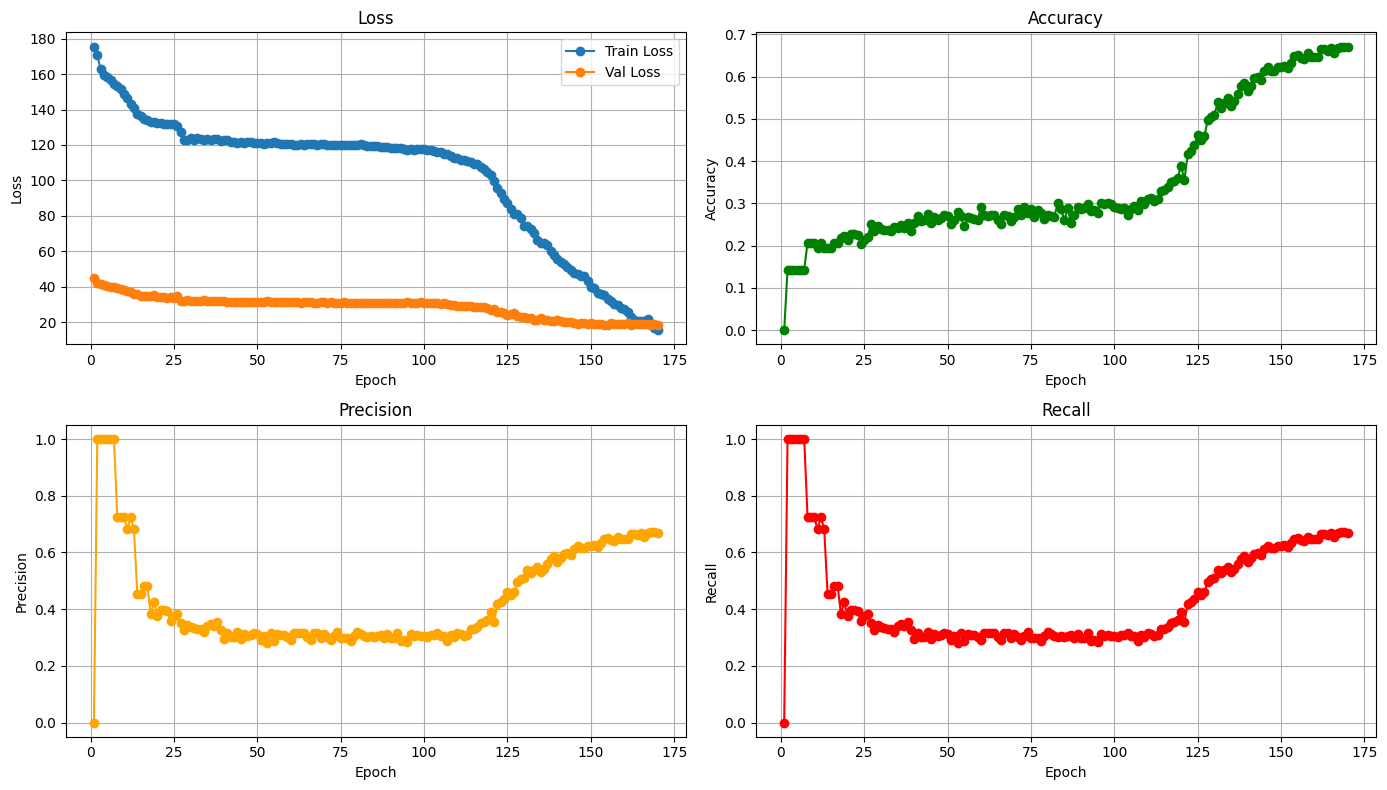

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, label='Accuracy', color='green', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, val_precisions, label='Precision', color='orange', marker='o')
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, val_recalls, label='Recall', color='red', marker='o')
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()